In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import timm
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch



class SwinBackboneMultiLevel(nn.Module):
    def __init__(self, model_name="swin_tiny_patch4_window7_224", embed_dim=256, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=True,
            out_indices=(1, 2, 3)
        )
        in_channels = self.backbone.feature_info.channels()
        
        # Project each feature map to same dim
        self.proj_layers = nn.ModuleList([
            nn.Conv2d(in_ch, embed_dim, kernel_size=1) for in_ch in in_channels
        ])

    def forward(self, x):
        feats = self.backbone(x)
        outs = {}
        for i, (f, proj) in enumerate(zip(feats, self.proj_layers)):
             # Ensure channels-first
            if f.shape[-1] == self.backbone.feature_info.channels()[i]:
                # f is [B, H, W, C], convert to [B, C, H, W]
                f = f.permute(0, 3, 1, 2).contiguous()
            outs[f"C{i+3}"] = proj(f)
        return outs


class FPNFusion(nn.Module):
    def __init__(self, in_channels=256):
        super().__init__()
        self.smooth3 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.smooth4 = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.smooth5 = nn.Conv2d(in_channels, in_channels, 3, padding=1)

    def forward(self, c3, c4, c5):
        p5 = c5
        p4 = c4 + F.interpolate(p5, size=c4.shape[-2:], mode='nearest')
        p3 = c3 + F.interpolate(p4, size=c3.shape[-2:], mode='nearest')

        p3 = self.smooth3(p3)
        p4 = self.smooth4(p4)
        p5 = self.smooth5(p5)
        return {"P3": p3, "P4": p4, "P5": p5}

device = torch.device("mps")


backbone = SwinBackboneMultiLevel(embed_dim=256).to(device)
fpn = FPNFusion(in_channels=256).to(device)


img = Image.open("/Users/preetamverma/Desktop/image_cap_model_test_images/gettyimages-144103223-2048x2048.jpg").convert("RGB") 
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
x = transform(img).unsqueeze(0)  # [1, 3, 224, 224]
x = x.to(device)

with torch.no_grad():
    feats = backbone(x) 
    fpn_feats = fpn(feats["C3"], feats["C4"], feats["C5"])  # P3, P4, P5

In [ ]:
fpn_feats

In [ ]:
def show_feature_map(feat, title):
    # feat: [B, C, H, W]
    fmap = feat[0].mean(0).cpu()  # average over channels
    plt.imshow(fmap, cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
# Raw Swin outputs
# show_feature_map(feats["C3"], "C3 - Raw Swin")
show_feature_map(feats["C4"], "C4 - Raw Swin")
show_feature_map(feats["C5"], "C5 - Raw Swin")

# FPN fused outputs
# show_feature_map(fpn_feats["P3"], "P3 - FPN Fusion")
# show_feature_map(fpn_feats["P4"], "P4 - FPN Fusion")
show_feature_map(fpn_feats["P5"], "P5 - FPN Fusion")

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "grounding_dino_tiny_local"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id)


tokenizer = processor.tokenizer
vocab_size = len(tokenizer)
print ("Before")
print("Tokenizer vocab size:", vocab_size)

embed_layer =  model.model.text_backbone.get_input_embeddings()
print("Embedding layer size:", embed_layer.weight.size())

new_tokens = ["button", "flexcontainer"]
added_tokens = tokenizer.add_tokens(new_tokens)
print("Added tokens:", added_tokens)

if added_tokens > 0:
    model.model.text_backbone.resize_token_embeddings(len(tokenizer))
print ("After")

vocab_size = len(tokenizer)
print("Tokenizer vocab size:", vocab_size)

embed_layer = model.model.text_backbone.get_input_embeddings()
print("Embedding layer size:", embed_layer.weight.size())




In [ ]:
from transformers import AutoProcessor, GroundingDinoForObjectDetection

processor = AutoProcessor.from_pretrained(model_id)
model = GroundingDinoForObjectDetection.from_pretrained(model_id)

# Print submodules
for name, module in model.named_modules():
    if "text" in name.lower() or "lang" in name.lower():
        print(name, type(module))


In [ ]:
tokens_id = tokenizer.encode("flexcontainer")
tokens_id

In [ ]:
tokenizer.convert_ids_to_tokens(tokens_id)

In [ ]:
from PIL import Image
image = Image.open("/Users/preetamverma/Desktop/image_cap_model_test_images/gettyimages-144103223-2048x2048.jpg").convert("RGB")
text = ["a ceramic mug on the table"]

inputs = processor(images=image, text=text, return_tensors="pt")
outputs = model(**inputs)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import AutoProcessor
from transformers.models.grounding_dino import GroundingDinoForObjectDetection
import os 
from dotenv import load_dotenv
from transformers import GroundingDinoConfig
import torch 

load_dotenv()

device = torch.device("mps")


model_id = "IDEA-Research/grounding-dino-tiny"
# # Load model directly
# from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
# model = AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny")


# # load default config
config = GroundingDinoConfig()

# # override hidden dimension
# config.d_model = 256  # example: change to 512 instead of 256


# # optionally adjust other linked dimensions:
# # e.g., if number of heads n_head is set, ensure d_model % n_head == 0
# config.encoder_attention_heads = 16
# config.decoder_attention_heads = 16
# # Possibly adjust feedforward size:
# config.encoder_ffn_dim = 2048
# config.decoder_ffn_dim = 2048

# model = GroundingDinoForObjectDetection()

processor = AutoProcessor.from_pretrained(model_id)

# # For example override defaults:
# processor.do_resize = True                # whether to resize
# processor.size = {"height": 800,           # set target height
#                   "width": 1333}           # set target width
# processor.do_normalize = True              # whether to normalize pixel values
# processor.image_mean = [0.485, 0.456, 0.406]
# processor.image_std = [0.229, 0.224, 0.225]



from transformers.models.grounding_dino import GroundingDinoForObjectDetection

model = GroundingDinoForObjectDetection.from_pretrained(model_id)
model = model.to(device)
tokenizer = processor.tokenizer


In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms


from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

from transformers.models.grounding_dino import GroundingDinoForObjectDetection, GroundingDinoConfig
import pandas as pd
import os 
import ast 
import numpy as np 


import json

with open("annotations/instances_train2017.json") as f:
    coco_ann = json.load(f)

coco_df = pd.DataFrame(coco_ann['annotations'])  # contains bbox, image_id, category_id

coco_images_df = pd.DataFrame(coco_ann['images'])  

coco_grouped = coco_df.groupby("image_id")



class RefCOCODataset(Dataset):

    def __init__(self, tokenizer, processor, dataset_split="train", auto_add_tokens=False):
        self.df = pd.read_parquet('coco_ref/ref_coco_train.parquet')
        self.df["img_path"] = self.df["image_id"].apply(lambda x: os.path.join("train2017", f"{x:012d}.jpg"))
        self.tokenizer = tokenizer
        self.processor = processor
        self.auto_add_tokens = auto_add_tokens


    def __len__(self):
        return len(self.df)


    def match_bbox(self, ref_bbox, coco_bboxes):
        """
        ref_bbox: [x, y, w, h]
        coco_bboxes: DataFrame with columns ['bbox', 'category_id']
        returns category_id
        """
        # convert to numpy arrays
        ref_bbox = np.array(ref_bbox, dtype=np.float32)
        
        for _, row in coco_bboxes.iterrows():
            coco_bbox = np.array(row['bbox'], dtype=np.float32)
            # check if IoU > threshold or exact match
            if np.allclose(ref_bbox, coco_bbox, atol=2.0):  # allow small rounding differences
                return int(row['category_id'])
        # fallback
        return 1


    def get_category_id(self, image_id, ref_bbox):
        category_id = 1
        if image_id in coco_grouped.groups:
            coco_bboxes = coco_grouped.get_group(image_id)
            category_id = self.match_bbox(ref_bbox, coco_bboxes)

        else:
            print ("Image not Found")
        
        if category_id:
            return category_id
        
        return 0 

    def __getitem__(self, idx):
        # Get row
        ex = self.df.iloc[idx]

        image_id = ex["image_id"]

        img = Image.open(ex["img_path"]).convert("RGB")
        # img = transform(img)

        bbox_list = ex["bbox"]

        bbox  =  [np.float64(float(bbox)) for bbox in bbox_list]

        # bbox = ast.literal_eval(bbox)  # [x, y, w, h]

        raw_sentences = ast.literal_eval(ex["raw_sentences"])

        text = raw_sentences[0]["raw"].lower()

        category_id = self.get_category_id(image_id, bbox)


        # Optionally extend tokenizer on the fly
        if self.auto_add_tokens:
            tokens = text.split()
            new_words = [t for t in tokens if t not in self.tokenizer.get_vocab()]
            if new_words:
                print (new_words)
                LLLL
                added = self.tokenizer.add_tokens(new_words)
                if added > 0:
                    model.text_encoder.resize_token_embeddings(len(self.tokenizer))
                    print(f" Added {added} new tokens:", new_words)

        return {"image": img, "text": text, "bbox": bbox, "class_labels": category_id}


In [ ]:
def collate_fn(batch):
    images = [item["image"] for item in batch]
    texts  = [list(item["text"]) for item in batch]
    encodings = processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True, size={"shortest_edge": 800, "longest_edge": 1333})

    labels = []
    for item in batch:
        if isinstance(item["class_labels"], list):
            class_labels = torch.tensor(item["class_labels"], dtype=torch.long)
            boxes = torch.tensor(item["bbox"], dtype=torch.float32)
        else:
            class_labels = torch.tensor([item["class_labels"]], dtype=torch.long)
            boxes = torch.tensor([item["bbox"]], dtype=torch.float32)
        
        labels.append({
            "class_labels": class_labels,
            "boxes": boxes
        })
   
    encodings["labels"] = labels
    
    return encodings


dataset = RefCOCODataset(tokenizer, processor, dataset_split="train", auto_add_tokens=False)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)


model.model.text_backbone.resize_token_embeddings(len(tokenizer))

for batch in data_loader:
    print (batch["pixel_values"].shape)
    print (batch["input_ids"].shape)
    print (batch["token_type_ids"].shape)

    new_batch = {}

    # for k, v in batch.items():
    #     if isinstance(v, list):
    #         new_batch[k] = v
    #     else:
    #         new_batch[k] = v.to(device)

    new_batch = {k: v.to(device) if torch.is_tensor(v) else v for k, v in batch.items()}


    print (new_batch.keys())
    print (new_batch)
    outputs = model(**new_batch)
    print (vars(outputs))
    break


In [ ]:
import torch 

device = torch.device("mps")

# Suppose two images:
images = [
    Image.open("/Users/preetamverma/Desktop/image_cap_model_test_images/gettyimages-144103223-2048x2048.jpg").convert("RGB"),
    Image.open("/Users/preetamverma/Desktop/image_cap_model_test_images/dog_and_person.jpg").convert("RGB"),

]

texts = [["number 2"], ["flexcontainer"]]

inputs = processor(
    images=images,
    text=texts,
    return_tensors="pt",
    padding=True,
    truncation=True
).to(device)


inputs["pixel_values"].shape

In [ ]:
images[0].width

In [ ]:
def visualize_boxes(image, boxes, labels, scores):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        box = box.cpu() 
        x0, y0, x1, y1 = box
        width, height = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x0, y0, f"{label}: {score:.2f}", color='white', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

In [ ]:

model = model.to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Then post-process:

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.3,
    target_sizes=[img.size[::-1] for img in images]
)

for result in results:
    print(result["boxes"], result["labels"], result["scores"])


output = results[0]

#output = {key:[val_list[0:2]]for key, val_list in output.items()}

visualize_boxes(images[0], output["boxes"], output["labels"], output["scores"]) 



In [ ]:
results

In [ ]:
outputs

In [ ]:
logits = outputs.logits

In [ ]:
logits.shape # [batch_size, num_queries, vocab_size]

In [ ]:
with open("annotations/instances_train2017.json") as f:
    coco_ann = json.load(f)

# convert list of annotations to DataFrame
coco_df = pd.DataFrame(coco_ann['annotations'])

In [ ]:
coco_df.columns

In [ ]:
with open("annotations/instances_train2017.json") as f:
    coco_ann = json.load(f)

coco_df = pd.DataFrame(coco_ann['annotations'])  # contains bbox, image_id, category_id

coco_images_df = pd.DataFrame(coco_ann['images'])  

coco_grouped = coco_df.groupby("image_id")


In [ ]:
import torch

def build_positive_map(text: str, phrases: list[str], tokenizer) -> torch.Tensor:
    """
    Builds a positive_map tensor of shape [num_phrases, num_tokens]
    aligning each phrase with the tokens that describe it.
    """
    # Tokenize with offsets
    encoding = tokenizer(text, return_offsets_mapping=True, add_special_tokens=True)
    
    #  Fix: offsets are nested under [0] since tokenizer returns batch dim
    offsets = encoding["offset_mapping"]
    if isinstance(offsets[0], list):
        offsets = offsets[0]  # shape: (num_tokens, 2)

    num_tokens = len(offsets)
    num_phrases = len(phrases)
    positive_map = torch.zeros((num_phrases, num_tokens), dtype=torch.bool)

    # Normalize text
    text_lower = text.lower()

    for i, phrase in enumerate(phrases):
        phrase = phrase.strip().lower()
        start_char = text_lower.find(phrase)
        if start_char == -1:
            continue
        end_char = start_char + len(phrase)

        # Iterate over token spans
        for j, span in enumerate(offsets):
            # Some tokenizers return (0, 0) for [CLS]/[SEP]
            if not isinstance(span, (list, tuple)) or len(span) != 2:
                continue
            start_tok, end_tok = span
            if end_tok > start_char and start_tok < end_char:
                positive_map[i, j] = True

    return positive_map


In [ ]:
import torch

def xywh_to_cxcywh(boxes: torch.Tensor) -> torch.Tensor:
    """
    Convert bounding boxes from (x, y, w, h) format to (cx, cy, w, h) format.
    
    Args:
        boxes (torch.Tensor): Tensor of shape (N, 4) with boxes in [x, y, w, h]
    
    Returns:
        torch.Tensor: Tensor of shape (N, 4) with boxes in [cx, cy, w, h]
    """
    x, y, w, h = boxes.unbind(-1)
    cx = x + w / 2
    cy = y + h / 2
    return torch.stack([cx, cy, w, h], dim=-1)


def xyxy_to_cxcywh(boxes: torch.Tensor) -> torch.Tensor:
    """
    Convert (x1, y1, x2, y2) to (cx, cy, w, h)
    """
    x1, y1, x2, y2 = boxes.unbind(-1)
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    return torch.stack([cx, cy, w, h], dim=-1)


def normalize_boxes(boxes: torch.Tensor, W: int, H: int) -> torch.Tensor:
    """
    Normalize (cx, cy, w, h) to [0,1] range
    """
    cx, cy, w, h = boxes.unbind(-1)
    cx = cx / W
    cy = cy / H
    w = w / W
    h = h / H
    return torch.stack([cx, cy, w, h], dim=-1)
    


def scale_boxes_to_encoder(boxes: torch.Tensor, W: int, H: int, W_proc: int, H_proc: int) -> torch.Tensor:
    """
    Scale boxes from original image to encoder input size.
    Works for boxes in (cx, cy, w, h) format.
    
    Args:
        boxes (torch.Tensor): Tensor of shape (N, 4) in [cx, cy, w, h]
        W, H: Original image width and height
        W_proc, H_proc: Encoder processed image width and height
    
    Returns:
        torch.Tensor: Scaled boxes in [cx, cy, w, h] format
    """
    cx, cy, w, h = boxes.unbind(-1)
    cx = cx * W_proc / W
    cy = cy * H_proc / H
    w = w * W_proc / W
    h = h * H_proc / H
    return torch.stack([cx, cy, w, h], dim=-1)


# # Example usage
# norm_boxes = torch.tensor([[50, 100, 200, 300]], dtype=torch.float32)  # x, y, w, h
# cxcy_boxes = xywh_to_cxcywh(norm_boxes)




In [ ]:
def visualize_boxes(image, boxes, labels, scores):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        x0, y0, x1, y1 = box
        width, height = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x0, y0, f"{label}: {score:.2f}", color='white', fontsize=12,
                bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

tensor([[False,  True,  True,  True, False]])
=
	 abs_boxes			 tensor([[0.5349, 0.5000, 0.4660, 0.8929]])
tensor(81261.2109, grad_fn=<AddBackward0>)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/preetamverma/Desktop/multimodel/.venv/lib/python3.12/site-packages/transformers/models/grounding_dino/processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  w

=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=
Result 0: tensor([[219.3221,  27.6063, 818.1659, 556.8903]], grad_fn=<IndexBackward0>), ['a happy dog'], tensor([0.6240], grad_fn=<IndexBackward0>)
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=


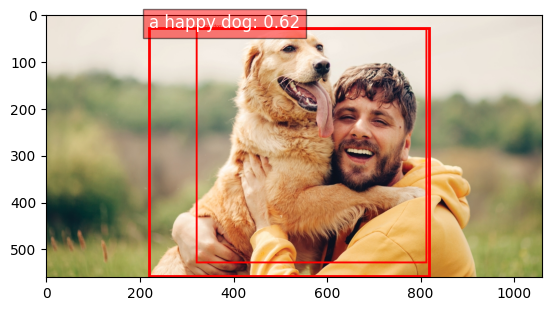

In [ ]:
from transformers import AutoProcessor
import torch
from PIL import Image
from transformers.models.grounding_dino import GroundingDinoForObjectDetection
from PIL import Image, ImageDraw, ImageFont


model_id = "IDEA-Research/grounding-dino-tiny"

image = Image.open("/Users/preetamverma/Desktop/multimodel/train2017/000000000025.jpg").convert("RGB")
text = "a giraffe"


processor = AutoProcessor.from_pretrained(model_id)

model = GroundingDinoForObjectDetection.from_pretrained(model_id)

tokenizer = processor.tokenizer 

enc = processor(images=image, text=text, return_tensors="pt")

pixel_values = enc["pixel_values"]


_, _, H_proc, W_proc = pixel_values.shape


text = "giraffe standing in the grass"
phrases = ["giraffe"]

positive_map = build_positive_map(text, phrases, tokenizer)

print (positive_map)
abs_boxes = []

Org_Image_Width, Org_Image_Height = image.size

norm_boxes = torch.tensor([[320, 30, 814, 530]], dtype=torch.float32)  # x, y, w, h
cxcy_boxes = xyxy_to_cxcywh(norm_boxes)
abs_boxes = normalize_boxes(cxcy_boxes, Org_Image_Width, Org_Image_Height)


#abs_boxes = torch.tensor(abs_boxes, dtype=torch.float32)

print ("=\n\t abs_boxes\t\t\t",abs_boxes)


labels = [{
    "class_labels": torch.tensor([0], dtype=torch.long),
    "boxes": abs_boxes,
    "positive_map": positive_map,
}]

outputs = model(**enc, labels=labels)
loss = outputs.loss

print (loss)


# ---- Visualization ----
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()


for i, (box, label_idx) in enumerate(zip(norm_boxes, labels[0]["class_labels"])):
    x0, y0, x1, y1 = box.tolist()
    color = "red" if i == 0 else "blue"
    label_text = phrases[label_idx]
    draw.rectangle([x0, y0, x1, y1], outline=color, width=4)
    draw.text((x0, y0 - 10), label_text, fill=color, font=font)

image.show()


# Then post-process:

results = processor.post_process_grounded_object_detection(
    outputs,
    enc.input_ids,
    threshold=0.3,
    target_sizes=[image.size[::-1]]
)

print ("=*="*70)
for i, result in enumerate(results):
    print(f"Result {i}: {result['boxes']}, {result['labels']}, {result['scores']}")
print ("=*="*70)


output = results[0]

#output = {key:[val_list[0]] for key, val_list in output.items()}

visualize_boxes(image, output["boxes"].detach().numpy(), output["labels"], output["scores"]) 


In [8]:
outputs.loss_dict

{'loss_ce': tensor(0.0749, grad_fn=<DivBackward0>),
 'loss_bbox': tensor(0.2186, grad_fn=<DivBackward0>),
 'loss_giou': tensor(0.2207, grad_fn=<DivBackward0>),
 'cardinality_error': tensor(899.),
 'loss_ce_enc': tensor(40629.3711, grad_fn=<DivBackward0>),
 'loss_bbox_enc': tensor(0.0923),
 'loss_giou_enc': tensor(0.1597),
 'cardinality_error_enc': tensor(899.)}